<a href="https://colab.research.google.com/github/Light0Yagami/Improving-Image-Fidelity-using-Deep-learning-algorithm/blob/main/image_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
np.random.seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
InputPath="/content/drive/MyDrive/LOLDataset/LOLdataset/our485/high"

#Noise Addition

In [ ]:
def addNoise(image):
    noiseAddedImage = image.copy()
    num_noise_pixels = int(np.ceil(image.size * 0.5))

    for _ in range(num_noise_pixels):
        x_coord = np.random.randint(0, image.shape[1])
        y_coord = np.random.randint(0, image.shape[0])
        noiseAddedImage[y_coord, x_coord] = 1

    return noiseAddedImage


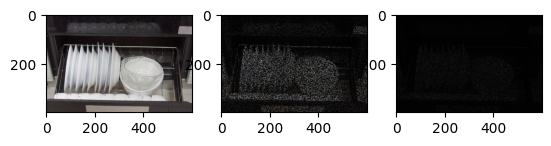

In [ ]:
img = cv.imread(InputPath+"/100.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
Noise = addNoise(img)
plt.imshow(Noise)
plt.subplot(1,3,3)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = addNoise(img1)
plt.imshow(Noise2)

In [ ]:
from tqdm import tqdm
HighPath = "/content/drive/MyDrive/LOLDataset/LOLdataset/our485/high"

def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageName in tqdm(os.listdir(HighPath)):
        count=count+1
        low_img = cv.imread(HighPath + "/" + imageName)
        if not os.path.isfile(HighPath + "/" + imageName):
            raise FileNotFoundError(f"Image not found: {HighPath + '/' + imageName}")
        low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)
        low_img = cv.resize(low_img,(500,500))
        hsv = cv.cvtColor(low_img, cv.COLOR_BGR2HSV)
        hsv[...,2] = hsv[...,2]*0.2
        img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        Noisey_img = addNoise(img_1)
        X_.append(Noisey_img)
        y_.append(low_img)
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [ ]:
X_,y_ = PreProcessData(InputPath)

100%|██████████| 485/485 [34:21<00:00,  4.25s/it]


In [ ]:
K.clear_session()
def InstantiateModel(in_):

    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)

    return model_5

In [ ]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 500, 500, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 500, 500, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 500, 500, 32)         4640      ['conv2d[0][0]']              
                                                                                              

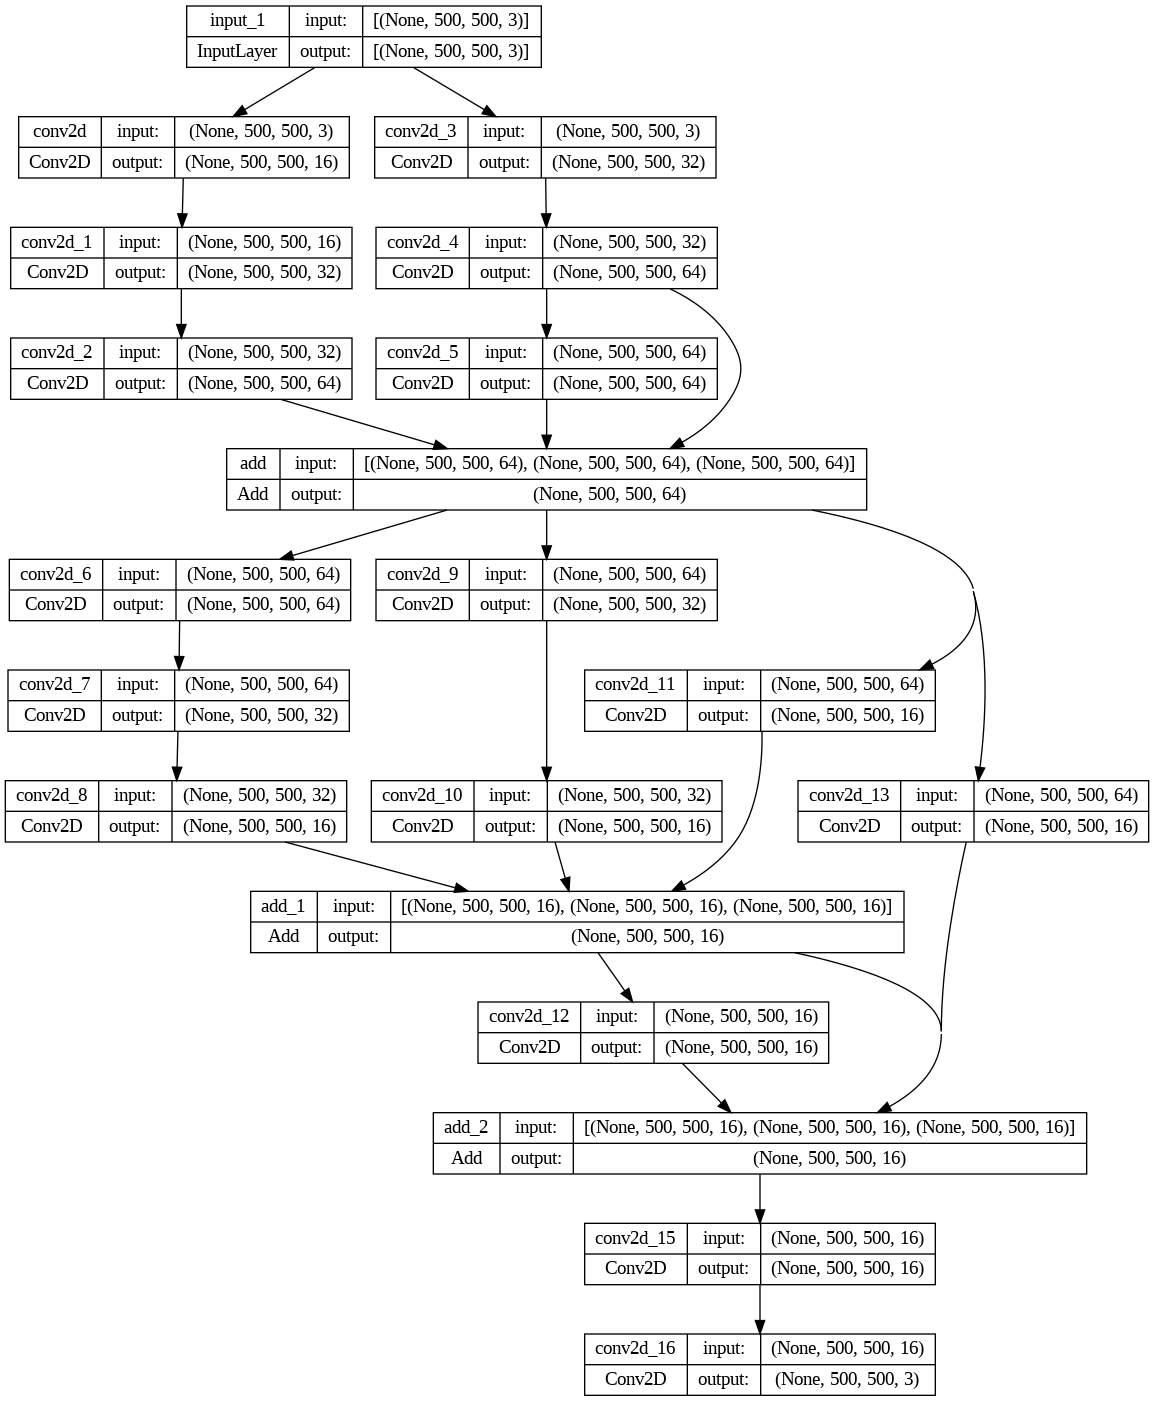

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')


In [ ]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=8,shuffle=True)


<ipython-input-13-48fe1ba6f2d0>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=8,shuffle=True)


Epoch 1/53
8/8 [==============================] - 95s 10s/step - loss: 8870.3271
Epoch 2/53
8/8 [==============================] - 84s 10s/step - loss: 6266.1040
Epoch 3/53
8/8 [==============================] - 84s 10s/step - loss: 4507.5625
Epoch 4/53
8/8 [==============================] - 82s 10s/step - loss: 1233.2573
Epoch 5/53
8/8 [==============================] - 82s 10s/step - loss: 845.7638
Epoch 6/53
8/8 [==============================] - 84s 10s/step - loss: 647.2308
Epoch 7/53
8/8 [==============================] - 83s 10s/step - loss: 481.9452
Epoch 8/53
8/8 [==============================] - 82s 10s/step - loss: 477.2001
Epoch 9/53
8/8 [==============================] - 84s 10s/step - loss: 370.2216
Epoch 10/53
8/8 [==============================] - 83s 10s/step - loss: 394.1401
Epoch 11/53
8/8 [==============================] - 81s 10s/step - loss: 461.7163
Epoch 12/53
8/8 [==============================] - 84s 10s/step - loss: 350.2687
Epoch 13/53
8/8 [================

In [ ]:
TestPath="/content/drive/MyDrive/LOLDataset/LOLdataset/our485/high"

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise


In [ ]:
ImagePath=TestPath+"/10.png"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [ ]:
import cv2
from cv2 import dnn_superres

In [ ]:
sr = dnn_superres.DnnSuperResImpl_create()

path = '/content/drive/MyDrive/model/EDSR_x4.pb'
sr.readModel(path)
sr.setModel("edsr", 4)

In [ ]:
sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)


In [ ]:
f_image = img_

In [ ]:
upscaled = sr.upsample(f_image)
cv2.imwrite('upscale.png',upscaled)

In [ ]:
bicubic = cv2.resize(f_image, (upscaled.shape[1], upscaled.shape[0]) interpolation=cv2.INTER_CUBIC)
cv2.imwrite('bicubic.png',bicubic)

In [ ]:
cv2.imshow(upscale.png)